# 数据挖掘互评作业四：离群点分析与异常检测

1. 问题描述

  本次作业将从Anomaly Detection Meta-Analysis Benchmarks提供的benchmark数据集中任选两个进行分析。

2. 数据来源

  Anomaly Detection Meta-Analysis Benchmarks  
  注意：第一个不是数据集，是用于生成benchmark数据的代码。  
  可以使用Python Outlier Detection (PyOD)或其他已知的工具包来完成分析工作。  

3. 提交的内容

  完整的分析代码  
  分析报告：展示分析的思路，详细过程，结果及你的分析。  
  所选择的数据集在README中说明，数据文件不要上传到Github中  
  乐学平台提交注意事项：  
  仓库地址：记得加上  
  报告：附件，word，pdf，html格式都可以  

In [13]:
import os
from google.colab import drive
drive.mount('/content/drive') # mount google drive
co_path = '/content/drive/My Drive/Colab Notebooks/dataMining'
os.chdir(co_path)
# os.listdir(co_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
!pip3 install pyod

In [15]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import math
import re
import sys
import csv
import os

import warnings

warnings.filterwarnings('ignore')

## 1 下载数据集 
Download Wave_benchmarks

In [6]:
#!wget https://ir.library.oregonstate.edu/downloads/jh343z59f?locale=en -O wave_benchmarks.zip

--2020-07-01 07:22:07--  https://ir.library.oregonstate.edu/downloads/jh343z59f?locale=en
Resolving ir.library.oregonstate.edu (ir.library.oregonstate.edu)... 128.193.164.152
Connecting to ir.library.oregonstate.edu (ir.library.oregonstate.edu)|128.193.164.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 964174119 (920M) [application/zip]
Saving to: ‘wave_benchmarks.zip’

wave_benchmarks.zip 100%[===================>] 919.51M  21.7MB/s    in 52s     

2020-07-01 07:23:01 (17.7 MB/s) - ‘wave_benchmarks.zip’ saved [964174119/964174119]



### 加载并分析wave_benchmarks数据集的文件组成
该数据集在wave.original.csv的基础上处理后的数据共有1080个csv文件，分别添加了不同的噪声。




In [16]:
import glob
import zipfile

zf = zipfile.ZipFile('wave_benchmarks.zip')
print('fileNamelist',len(zf.namelist()))
zf.namelist()[:15]

fileNamelist 1092


['wave/',
 'wave/HELP-README',
 'wave/CREATIVE-COMMONS-ATTRIBUTION-LICENSE-4.0',
 'wave/LICENSE-README',
 'wave/meta_data/',
 'wave/meta_data/wave.preproc.csv',
 'wave/meta_data/wave.diff.csv',
 'wave/meta_data/meta_wave.csv',
 'wave/meta_data/wave.original.csv',
 'wave/meta_data/notes.txt',
 'wave/meta_data/wave.original.dat',
 'wave/benchmarks/',
 'wave/benchmarks/wave_benchmark_0252.csv',
 'wave/benchmarks/wave_benchmark_1005.csv',
 'wave/benchmarks/wave_benchmark_0105.csv']

In [18]:
# 训练和测试所需的文件列表
data_csvs = list(filter(lambda f: f.startswith('wave/benchmarks/wave_benchmark_'),zf.namelist()))
len(data_csvs)

1080

In [19]:
# 读取并合并整个数据集，即合并所有1080个csv文件的数据
%%time
dfs = [pd.read_csv(zf.open(f)) for f in data_csvs]
wave = pd.concat(dfs,ignore_index=True)

CPU times: user 58.7 s, sys: 2.28 s, total: 1min
Wall time: 1min 2s


## 2 分析数据集特征（列）
合并后的数据集共有90列

In [20]:
print(wave.shape)
wave.head(10)

(2632953, 90)


,point.id,motherset,origin,original.label,diff.score,ground.truth,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8,V.9,V.10,V.11,V.12,V.13,V.14,V.15,V.16,V.17,V.18,V.19,V.20,noise..1,noise..2,noise..3,noise..4,noise..5,noise..6,noise..7,noise..8,noise..9,noise..10,noise..11,noise..12,noise..13,...,noise..24,noise..25,noise..26,noise..27,noise..28,noise..29,noise..30,noise..31,noise..32,noise..33,noise..34,noise..35,noise..36,noise..37,noise..38,noise..39,noise..40,noise..41,noise..42,noise..43,noise..44,noise..45,noise..46,noise..47,noise..48,noise..49,noise..50,noise..51,noise..52,noise..53,noise..54,noise..55,noise..56,noise..57,noise..58,noise..59,noise..60,noise..61,noise..62,noise..63
0,wave_point_1046,wave,multiclass,2,0.595948,nominal,-0.262485,-0.017791,-0.507116,-0.092995,-0.131615,-1.409615,-0.432492,-1.414166,-2.009339,-1.402977,-0.489510,0.361259,0.793837,0.250761,1.244488,1.380415,2.182683,1.004645,0.708678,-0.089981,-0.710709,1.984393,-0.618875,-0.907233,0.779432,-0.448056,-0.447375,0.860908,1.380867,-0.464196,-0.984291,0.631348,0.511429,0.990489,...,-0.536343,-0.851441,0.203162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,wave_point_0839,wave,multiclass,0,0.644188,anomaly,-0.707972,-1.099738,-1.508825,-0.255512,-0.638082,-0.952110,-0.740066,-1.259533,-0.842966,-0.893675,0.665271,-0.980936,0.036990,1.034802,1.358418,0.977253,1.290440,1.004645,0.382952,-0.117725,-0.470002,-1.527382,0.836383,0.284421,-0.815015,-0.489510,0.510074,0.578270,-0.836668,0.900580,-0.255251,1.611616,-0.835407,-0.984291,...,0.269296,-0.482146,1.754317,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,wave_point_2061,wave,multiclass,1,0.371222,nominal,-1.846439,-0.720107,0.040036,2.055052,0.928988,0.089679,1.507210,0.269619,0.557883,0.464466,-0.424368,-1.185901,-1.912649,-0.783263,-1.484899,-0.149393,0.152680,-0.644544,-0.585874,-0.080733,0.412589,0.931567,2.014449,-1.476112,-0.947886,0.736334,1.507210,0.288566,-1.193058,-1.125541,-0.340187,0.575861,-0.010470,-0.418046,...,0.846470,-0.198074,-1.594495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,wave_point_3959,wave,multiclass,0,0.530739,anomaly,-1.331654,-1.014321,-1.197369,0.055390,-1.210093,-1.431664,-1.310567,-1.494346,-0.590453,-1.579274,-0.501354,-0.551169,0.333674,1.932471,1.487210,1.015912,2.200647,-0.057065,0.575047,0.344666,0.442678,2.747515,0.093905,-0.763516,0.238459,1.399593,-0.749988,-0.128325,-1.212857,1.375546,-1.147087,0.705331,0.452505,-1.083384,...,0.924629,0.438249,0.870519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,wave_point_0266,wave,multiclass,1,0.803224,nominal,-0.193187,0.826886,1.075416,1.291930,1.226910,1.247222,1.839588,0.429979,-0.295853,-0.710848,0.019778,-1.906588,-0.513995,-0.436695,-0.811221,-0.696148,-0.655728,-0.998448,-0.068053,1.371173,0.091647,-0.601743,1.271971,0.535925,-1.991869,-1.573227,0.490231,-0.799589,-0.589175,-0.830942,-0.800262,1.417412,-0.187242,1.224065,...,1.273338,-0.044674,0.106966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,wave_point_2630,wave,multiclass,0,0.260454,anomaly,-2.440422,2.867399,1.395290,2.309426,1.089866,1.423609,1.532014,1.363506,-0.133523,0.425289,-0.909969,-1.648727,-1.325336,-1.050292,-0.925152,-1.999523,-0.937174,-0.340187,0.767141,1.001261,0.522913,0.168445,0.628489,0.901206,0.228968,-1.058017,-1.494119,-0.262578,1.816455,1.297387,0.912630,1.445156,-0.338761,-0.743637,...,-0.374012,0.921173,1.549901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [21]:
wave.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632953 entries, 0 to 2632952
Data columns (total 90 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   point.id        2632953 non-null  object 
 1   motherset       2632953 non-null  object 
 2   origin          2632953 non-null  object 
 3   original.label  2632953 non-null  int64  
 4   diff.score      2632953 non-null  float64
 5   ground.truth    2632953 non-null  object 
 6   V               2632953 non-null  float64
 7   V.1             2632953 non-null  float64
 8   V.2             2632953 non-null  float64
 9   V.3             2632953 non-null  float64
 10  V.4             2632953 non-null  float64
 11  V.5             2632953 non-null  float64
 12  V.6             2632953 non-null  float64
 13  V.7             2632953 non-null  float64
 14  V.8             2632953 non-null  float64
 15  V.9             2632953 non-null  float64
 16  V.10            2632953 non-null  fl

## 3 数据集预处理
因为合并后的数据集某些列的值为NAN，因此抽取1080个csv文件的共有特征进行训练和预测

In [22]:
select_features = ['V', 'V.1', 'V.2', 'V.3', 'V.4', 'V.5', 'V.6', 'V.7', 'V.8', 'V.9','V.10', 
                   'V.11', 'V.12', 'V.13', 'V.14', 'V.15', 'V.16', 'V.17', 'V.18', 'V.19', 'V.20',
                   'ground.truth']
sel_wave = wave[select_features]

In [25]:
print(sel_wave.shape)
sel_wave.head(10)

(2632953, 22)


,V,V.1,V.2,V.3,V.4,V.5,V.6,V.7,V.8,V.9,V.10,V.11,V.12,V.13,V.14,V.15,V.16,V.17,V.18,V.19,V.20,ground.truth
0,-0.262485,-0.017791,-0.507116,-0.092995,-0.131615,-1.409615,-0.432492,-1.414166,-2.009339,-1.402977,-0.489510,0.361259,0.793837,0.250761,1.244488,1.380415,2.182683,1.004645,0.708678,-0.089981,-0.710709,nominal
1,-0.707972,-1.099738,-1.508825,-0.255512,-0.638082,-0.952110,-0.740066,-1.259533,-0.842966,-0.893675,0.665271,-0.980936,0.036990,1.034802,1.358418,0.977253,1.290440,1.004645,0.382952,-0.117725,-0.470002,anomaly
2,-1.846439,-0.720107,0.040036,2.055052,0.928988,0.089679,1.507210,0.269619,0.557883,0.464466,-0.424368,-1.185901,-1.912649,-0.783263,-1.484899,-0.149393,0.152680,-0.644544,-0.585874,-0.080733,0.412589,nominal
3,-1.331654,-1.014321,-1.197369,0.055390,-1.210093,-1.431664,-1.310567,-1.494346,-0.590453,-1.579274,-0.501354,-0.551169,0.333674,1.932471,1.487210,1.015912,2.200647,-0.057065,0.575047,0.344666,0.442678,anomaly
4,-0.193187,0.826886,1.075416,1.291930,1.226910,1.247222,1.839588,0.429979,-0.295853,-0.710848,0.019778,-1.906588,-0.513995,-0.436695,-0.811221,-0.696148,-0.655728,-0.998448,-0.068053,1.371173,0.091647,nominal
5,-2.440422,2.867399,1.395290,2.309426,1.089866,1.423609,1.532014,1.363506,-0.133523,0.425289,-0.909969,-1.648727,-1.325336,-1.050292,-0.925152,-1.999523,-0.937174,-0.340187,0.767141,1.001261,0.522913,anomaly
6,-1.747442,-0.046264,-0.044141,-1.089293,-0.691708,-1.095425,-0.472179,-0.961720,-2.069461,-1.213621,-0.832983,0.427377,1.132905,0.585967,1.591234,1.275483,1.248522,1.514266,-0.310260,1.306438,-2.245214,anomaly
7,0.054306,0.845867,-0.574457,-1.520316,-0.941963,-0.461532,-0.472179,-0.532184,-1.191675,-0.645553,-0.637559,0.037281,1.756547,1.773391,1.497117,0.264815,1.775484,2.016809,0.190857,-0.173212,-0.419855,anomaly
8,0.311698,-0.606218,-1.643508,-0.743062,0.237809,-0.037100,-0.159644,-1.385530,-0.061376,-1.592333,0.416549,0.076952,0.261017,0.176902,1.829002,0.502294,1.014982,0.735679,0.984292,-0.274937,0.994297,nominal
9,-0.242686,-0.881450,-0.010470,-0.714798,0.112681,0.006997,-1.032758,-2.376328,-1.029345,-0.299488,-1.247520,-0.432156,0.539537,1.358645,0.451925,1.330710,0.961088,1.705374,0.499879,0.548118,0.954179,anomaly


In [24]:
sel_wave.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2632953 entries, 0 to 2632952
Data columns (total 22 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   V             2632953 non-null  float64
 1   V.1           2632953 non-null  float64
 2   V.2           2632953 non-null  float64
 3   V.3           2632953 non-null  float64
 4   V.4           2632953 non-null  float64
 5   V.5           2632953 non-null  float64
 6   V.6           2632953 non-null  float64
 7   V.7           2632953 non-null  float64
 8   V.8           2632953 non-null  float64
 9   V.9           2632953 non-null  float64
 10  V.10          2632953 non-null  float64
 11  V.11          2632953 non-null  float64
 12  V.12          2632953 non-null  float64
 13  V.13          2632953 non-null  float64
 14  V.14          2632953 non-null  float64
 15  V.15          2632953 non-null  float64
 16  V.16          2632953 non-null  float64
 17  V.17          2632953 non-n

In [26]:
np.unique(sel_wave['ground.truth'].values)

array(['anomaly', 'nominal'], dtype=object)

In [27]:
sel_wave['ground.truth'][sel_wave['ground.truth']!='nominal'] = 1
sel_wave['ground.truth'][sel_wave['ground.truth']=='nominal'] = 0

In [28]:
np.unique(sel_wave['ground.truth'].values)

array([0, 1], dtype=object)

## 4 离群点与异常点检测


### 4.1 数据集划分

In [30]:
## 去除重复数据
%%time
wave_unique = sel_wave.drop_duplicates()

CPU times: user 1.18 s, sys: 30.7 ms, total: 1.21 s
Wall time: 1.22 s


In [31]:
wave_unique.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 68749
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   V             5000 non-null   float64
 1   V.1           5000 non-null   float64
 2   V.2           5000 non-null   float64
 3   V.3           5000 non-null   float64
 4   V.4           5000 non-null   float64
 5   V.5           5000 non-null   float64
 6   V.6           5000 non-null   float64
 7   V.7           5000 non-null   float64
 8   V.8           5000 non-null   float64
 9   V.9           5000 non-null   float64
 10  V.10          5000 non-null   float64
 11  V.11          5000 non-null   float64
 12  V.12          5000 non-null   float64
 13  V.13          5000 non-null   float64
 14  V.14          5000 non-null   float64
 15  V.15          5000 non-null   float64
 16  V.16          5000 non-null   float64
 17  V.17          5000 non-null   float64
 18  V.18          5000 non-null

按照80%训练集，20%测试集进行划分

In [32]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(wave_unique, test_size=0.2, random_state=113)

In [33]:
y_train = train['ground.truth'].values
y_train = y_train.astype(np.int32)
X_train = train.drop('ground.truth',axis=1).values

y_test = test['ground.truth'].values
y_test = y_test.astype(np.int32)
X_test = test.drop('ground.truth',axis=1).values

In [34]:
from sklearn.utils.multiclass import type_of_target
type_of_target(y_train)

'binary'

### 4.2 t-SNE 降维，可视化

In [35]:
from sklearn.manifold import TSNE

In [38]:
%%time
tsne_X_train = TSNE(n_components=2,random_state=113,
                    init='pca',n_iter=2000).fit_transform(X_train)

tsne_X_test =  TSNE(n_components=2,random_state=113,
                    init='pca',n_iter=2000).fit_transform(X_test)

CPU times: user 2min 36s, sys: 740 ms, total: 2min 36s
Wall time: 1min 19s


### 4.3 方法比较
+ 单一数据模型
  - KNN
  - PCA
  - LOF
+ 组合模型
  - Average: average scores of all detectors.
  - maximization: maximum score across all detectors.
  - Average of Maximum (AOM): divide base detectors into subgroups and take the maximum score for each subgroup. The final score is the average of all subgroup scores.
  - Maximum of Average (MOA): divide base detectors into subgroups and take the average score for each subgroup. The final score is the maximum of all subgroup scores.

#### KNN

In [39]:
%%time
from pyod.models.knn import KNN

clf_name = "KNN"
clf = KNN()
clf.fit(X_train)

y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_

y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

CPU times: user 1.4 s, sys: 1.96 ms, total: 1.41 s
Wall time: 1.41 s


In [40]:
from pyod.utils.data import evaluate_print
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
KNN ROC:0.5276, precision @ rank n:0.3403

On Test Data:
KNN ROC:0.5287, precision @ rank n:0.3498


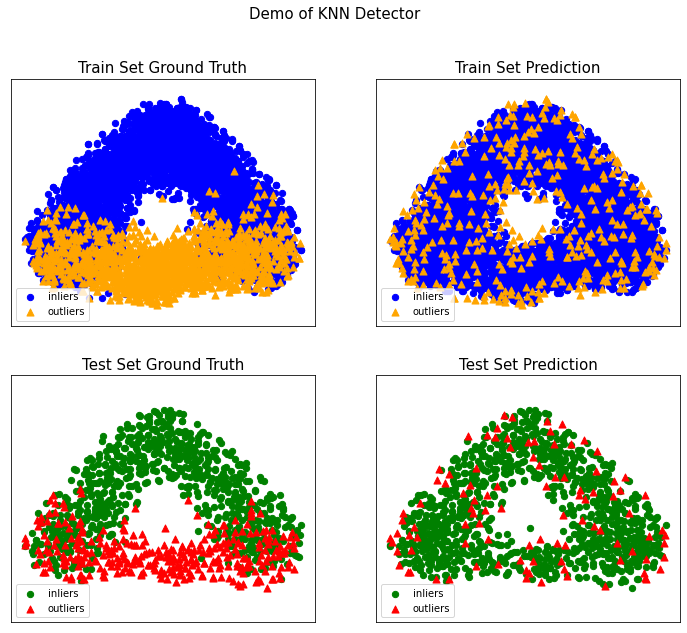

CPU times: user 297 ms, sys: 1.96 ms, total: 298 ms
Wall time: 301 ms


In [42]:
%%time
from pyod.utils.example import visualize
visualize(clf_name, tsne_X_train, y_train, tsne_X_test, y_test, y_train_pred,
    y_test_pred, show_figure=True, save_figure=False)

#### PCA

In [43]:
%%time
from pyod.models.pca import PCA
clf_name = 'PCA'
clf = PCA(n_components=3)
clf.fit(X_train)

y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_

y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

CPU times: user 20.6 ms, sys: 13.9 ms, total: 34.5 ms
Wall time: 22.1 ms


In [44]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
PCA ROC:0.5274, precision @ rank n:0.3688

On Test Data:
PCA ROC:0.5359, precision @ rank n:0.3777


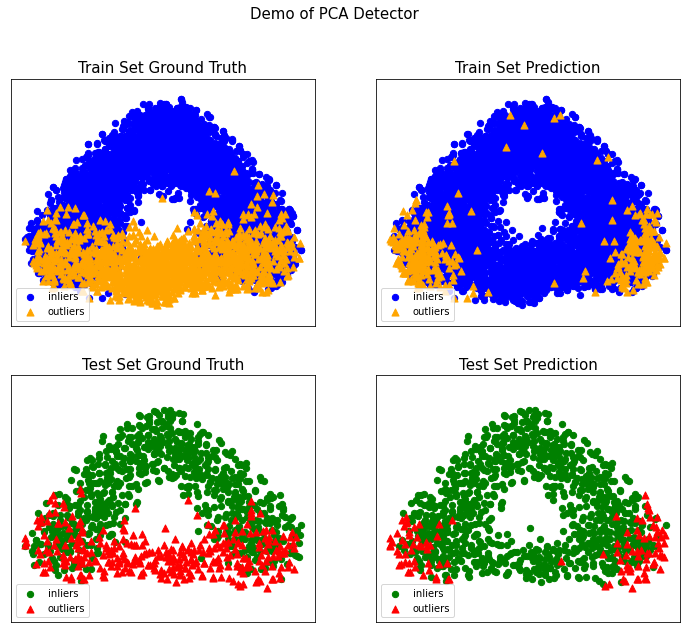

CPU times: user 439 ms, sys: 8.04 ms, total: 447 ms
Wall time: 450 ms


In [45]:
%%time
visualize(clf_name, tsne_X_train, y_train, tsne_X_test, y_test, y_train_pred,
    y_test_pred, show_figure=True, save_figure=False)

#### LOF

In [46]:
%%time
from pyod.models.lof import LOF

clf_name = "LOF"
clf = LOF()
clf.fit(X_train)

y_train_pred = clf.labels_
y_train_scores = clf.decision_scores_

y_test_pred = clf.predict(X_test)
y_test_scores = clf.decision_function(X_test)

CPU times: user 1.22 s, sys: 1.96 ms, total: 1.22 s
Wall time: 1.22 s


In [47]:
# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)


On Training Data:
LOF ROC:0.5065, precision @ rank n:0.3193

On Test Data:
LOF ROC:0.5097, precision @ rank n:0.3189


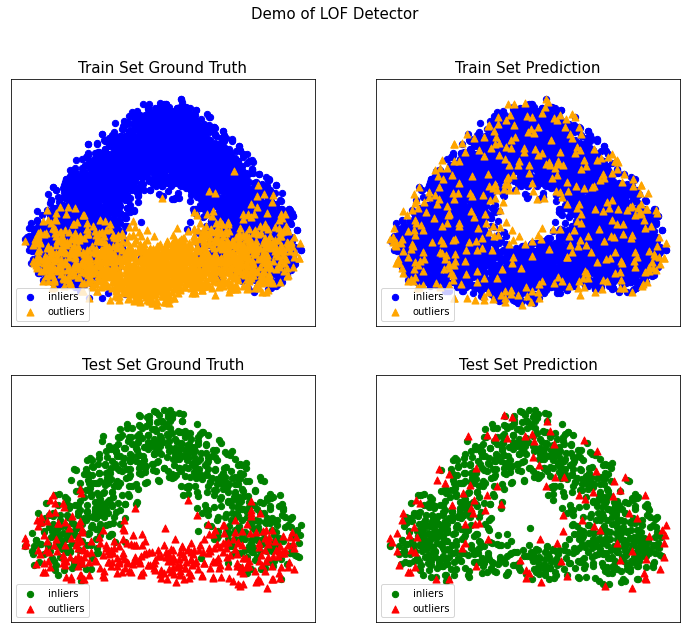

CPU times: user 298 ms, sys: 3.97 ms, total: 302 ms
Wall time: 304 ms


In [48]:
%%time
visualize(clf_name, tsne_X_train, y_train, tsne_X_test, y_test, y_train_pred,
    y_test_pred, show_figure=True, save_figure=False)

#### 组合模型

In [49]:
from pyod.models.combination import aom,moa,average,maximization
from pyod.utils.utility import standardizer

In [50]:
%%time
norm_X_train,norm_X_test = standardizer(X_train,X_test)

n_clf = 20 # initialize 20 base detectors for combination

k_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140,
            150, 160, 170, 180, 190, 200]

train_scores = np.zeros([norm_X_train.shape[0], n_clf])
test_scores = np.zeros([norm_X_test.shape[0], n_clf])

for i in range(n_clf):
    k = k_list[i]

    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(norm_X_train)

    train_scores[:, i] = clf.decision_scores_
    test_scores[:, i] = clf.decision_function(norm_X_test)

CPU times: user 26.2 s, sys: 130 ms, total: 26.4 s
Wall time: 26.4 s


In [52]:
%%time
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores, test_scores)

comb_by_average = average(test_scores_norm)
comb_by_maximization = maximization(test_scores_norm)
comb_by_aom = aom(test_scores_norm, 5) # 5 groups
comb_by_moa = moa(test_scores_norm, 5) # 5 groups


CPU times: user 8.1 ms, sys: 1.03 ms, total: 9.14 ms
Wall time: 10.6 ms


In [54]:
%%time
print("\nOn Test Data:")
evaluate_print('Combination by Average', y_test, comb_by_average)
evaluate_print('Combination by Maximization', y_test, comb_by_maximization)
evaluate_print('Combination by AOM', y_test, comb_by_aom)
evaluate_print('Combination by MOA', y_test, comb_by_moa)


On Test Data:
Combination by Average ROC:0.5389, precision @ rank n:0.3467
Combination by Maximization ROC:0.5359, precision @ rank n:0.3437
Combination by AOM ROC:0.5377, precision @ rank n:0.3437
Combination by MOA ROC:0.5386, precision @ rank n:0.3529
CPU times: user 14.9 ms, sys: 980 µs, total: 15.8 ms
Wall time: 17.4 ms


## 5 单独分析某个csv文件
对每个benchmars的csv文件单独使用KNN，PCA，LOF三种模型进行离群点和异常点检测。

In [56]:
from sklearn.utils import column_or_1d
from sklearn.utils import check_consistent_length
from sklearn.metrics import roc_auc_score

from pyod.utils.utility import precision_n_scores
import time

In [61]:
def data_label_split(data, label_column='ground.truth'):
    x = data.drop(label_column, axis=1)
    y = []
    for i in data[label_column].values:
        if i == 'nominal':
            y.append(0)
        else:
            y.append(1)
    y = np.array(y)
    return x, y
    
def evaluate(y, y_pred):
    y = column_or_1d(y)
    y_pred = column_or_1d(y_pred)
    check_consistent_length(y, y_pred)
    return np.round(roc_auc_score(y, y_pred), decimals=4), np.round(precision_n_scores(y, y_pred), decimals=4)

def tsne(original_data):
    # T-SNE Implementation
    t0 = time.time()
    reduced_tsne = TSNE(n_components=2, random_state=2020, init='pca').fit_transform(original_data.values)
    t1 = time.time()
    print("T-SNE took {:.2} s".format(t1 - t0))
    return reduced_tsne

# fit model in unsupervised manner and predict 
def model_evaluation(clf, data):
    X_train, y_train = data_label_split(data)
    clf.fit(X_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores
    roc, prn = evaluate(y_train, y_train_scores)
    return y_train_pred, roc, prn



In [58]:

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

def visualization(data, y_pred):
    X_train, y_train = data_label_split(data)
    X_reduced_tsne = tsne(X_train)
    f, (ax0, ax1) = plt.subplots(1, 2, figsize=(16,6))
    blue_patch = mpatches.Patch(color='#0A0AFF', label='nominal')
    red_patch = mpatches.Patch(color='#AF0000', label='anomaly')
    
     # true visualization
    ax0.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_train == 0), cmap='coolwarm', label='nominal', linewidths=2)
    ax0.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_train == 1), cmap='coolwarm', label='anomaly', linewidths=2)
    ax0.set_title('ground-truth t-SNE visualization', fontsize=14)

    ax0.legend(handles=[blue_patch, red_patch])
    ax0.set_xticks([])
    ax0.set_yticks([])

    # predicted visualization
    ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_pred == 0), cmap='coolwarm', label='nominal', linewidths=2)
    ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y_pred == 1), cmap='coolwarm', label='anomaly', linewidths=2)
    ax1.set_title('prediction t-SNE visualization', fontsize=14)

    ax1.legend(handles=[blue_patch, red_patch])
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    plt.show()

In [59]:
import prettytable as pt


99 wave/benchmarks/wave_benchmark_1607.csv
best model: KNN ROC: 0.645 precision @ rank n: 0.2209
T-SNE took 3.2e+01 s


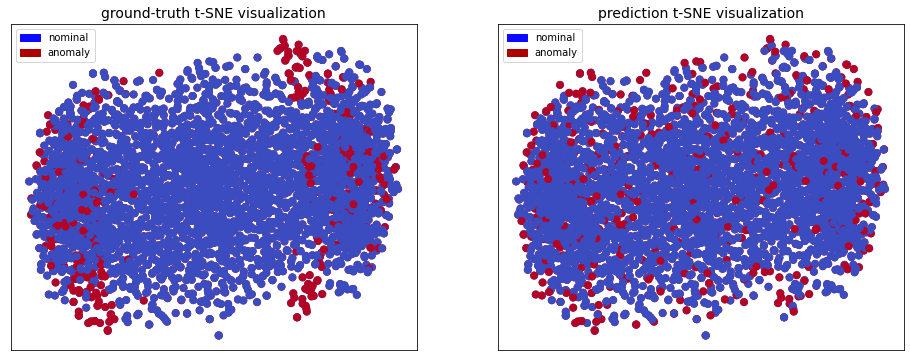

199 wave/benchmarks/wave_benchmark_0375.csv
best model: LOF ROC: 0.7802 precision @ rank n: 0.0
T-SNE took 3e+01 s


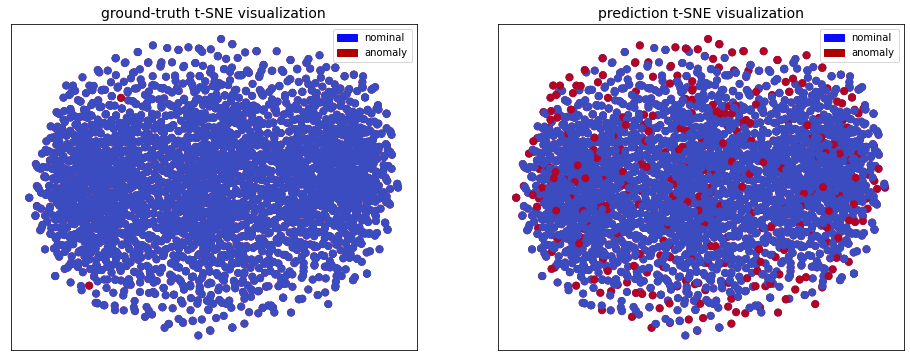

299 wave/benchmarks/wave_benchmark_0712.csv
best model: LOF ROC: 0.7347 precision @ rank n: 0.0
T-SNE took 3e+01 s


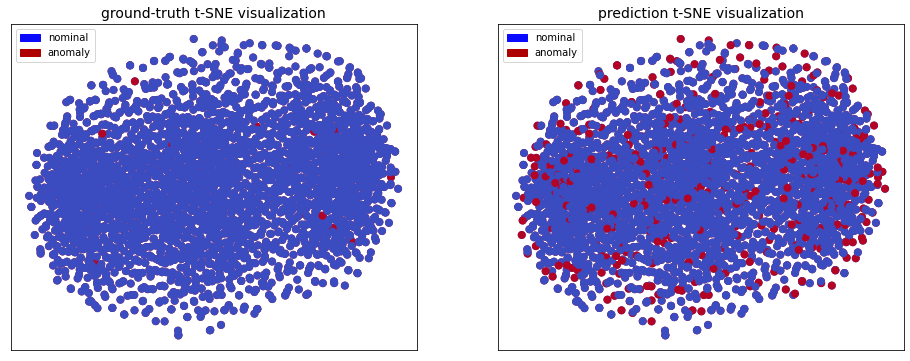

399 wave/benchmarks/wave_benchmark_0334.csv
best model: PCA ROC: 0.8493 precision @ rank n: 0.0
T-SNE took 3e+01 s


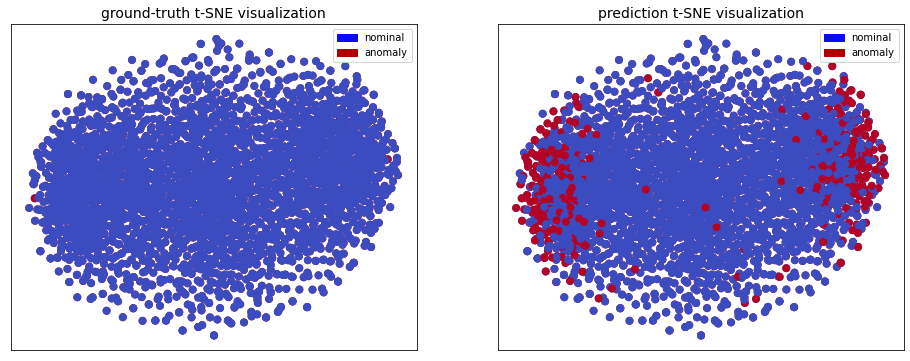

499 wave/benchmarks/wave_benchmark_0399.csv
best model: KNN ROC: 0.823 precision @ rank n: 0.0
T-SNE took 3.4e+01 s


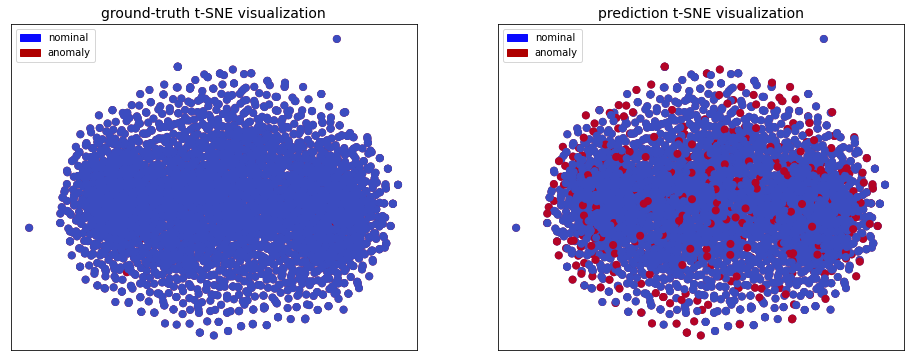

599 wave/benchmarks/wave_benchmark_0759.csv
best model: PCA ROC: 0.4943 precision @ rank n: 0.0
T-SNE took 9.6 s


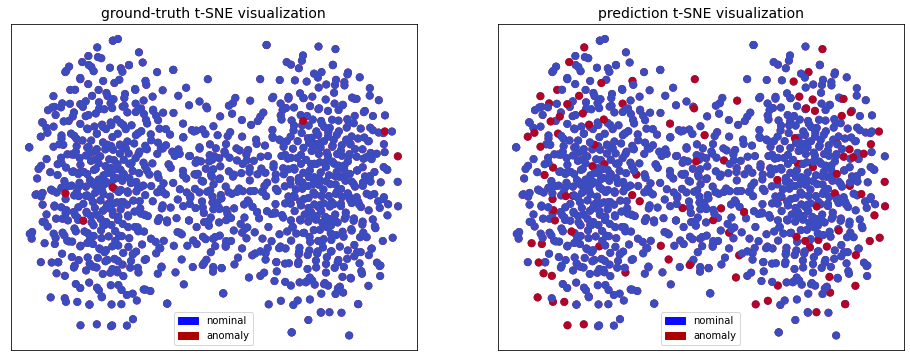

699 wave/benchmarks/wave_benchmark_0188.csv
best model: LOF ROC: 0.5086 precision @ rank n: 0.4876
T-SNE took 7.8 s


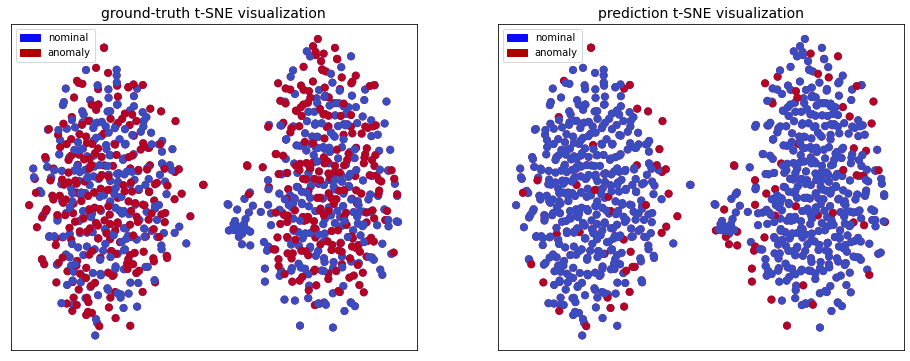

799 wave/benchmarks/wave_benchmark_1231.csv
best model: PCA ROC: 0.6489 precision @ rank n: 0.1258
T-SNE took 3.1e+01 s


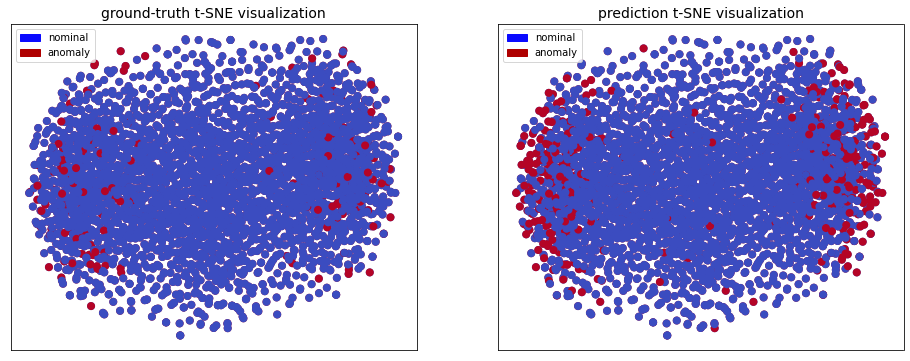

899 wave/benchmarks/wave_benchmark_1240.csv
best model: PCA ROC: 0.6458 precision @ rank n: 0.1006
T-SNE took 3.4e+01 s


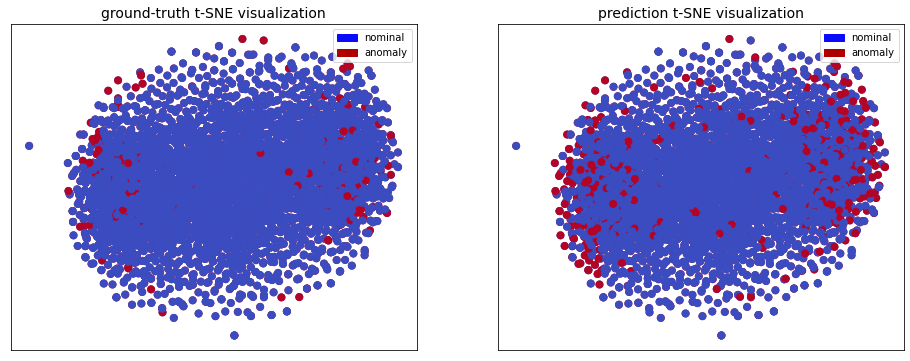

999 wave/benchmarks/wave_benchmark_1604.csv
best model: KNN ROC: 0.6593 precision @ rank n: 0.1881
T-SNE took 3.1e+01 s


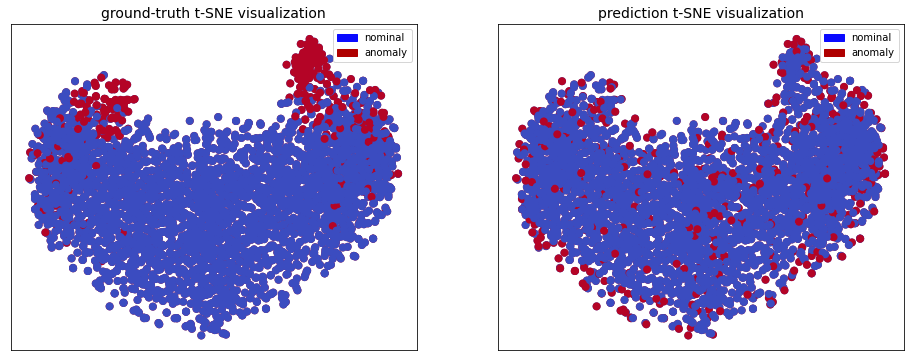

+-----------------------------------------+-------+--------+--------------------+
|                 csv_file                | model |  ROC   | precision @ rank n |
+-----------------------------------------+-------+--------+--------------------+
| wave/benchmarks/wave_benchmark_0252.csv |  KNN  | 0.4427 |       0.5351       |
| wave/benchmarks/wave_benchmark_0252.csv |  PCA  | 0.5121 |       0.5838       |
| wave/benchmarks/wave_benchmark_0252.csv |  LOF  | 0.4637 |       0.5568       |
| wave/benchmarks/wave_benchmark_1005.csv |  KNN  | 0.7327 |       0.1935       |
| wave/benchmarks/wave_benchmark_1005.csv |  PCA  | 0.6194 |       0.0323       |
| wave/benchmarks/wave_benchmark_1005.csv |  LOF  | 0.7417 |       0.1935       |
| wave/benchmarks/wave_benchmark_0105.csv |  KNN  | 0.5077 |       0.3429       |
| wave/benchmarks/wave_benchmark_0105.csv |  PCA  | 0.4775 |       0.332        |
| wave/benchmarks/wave_benchmark_0105.csv |  LOF  | 0.5129 |       0.333        |
| wave/benchmark

In [63]:
%%time
# Add or replace models
model_list = {'KNN': KNN(), 'PCA': PCA(), 'LOF': LOF()}

tb = pt.PrettyTable( ['csv_file', 'model', 'ROC', 'precision @ rank n'])
for i in range(len(data_csvs)):
    df = pd.read_csv(zf.open(data_csvs[i]))
    df = df.drop(['point.id', 'motherset', 'origin', 'original.label', 'diff.score'], axis=1)
    best_roc = 0
    best_model = None
    best_pred = None
    best_prn = None
    for model in model_list:
        y_train_pred, roc, prn = model_evaluation(model_list[model], df)
        tb.add_row([data_csvs[i], model, roc, prn])
        if roc >= best_roc:
            best_roc = roc
            best_pred = y_train_pred
            best_model = model
            best_prn = prn
    
    if (i + 1) % 100 == 0:
        # visualize once / 100 files
        print(i, data_csvs[i])
        print('best model:', best_model, 'ROC:', best_roc, 'precision @ rank n:', best_prn)
        visualization(df, best_pred)
print(tb)